In [1]:
# Python Libraries
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras import backend as K
import cv2
from scipy.ndimage import gaussian_filter

# Custom Networks
from networks.lenet import LeNet
from networks.resnet import ResNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

In [13]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
# Custom Networks
from networks.lenet import LeNet
from networks.resnet import ResNet

lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet]

Successfully loaded lenet
Successfully loaded resnet


In [15]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

In [16]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed[0])[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

In [17]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image[0])[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

In [18]:
def average_color_neighborhood(img, x, y, neighborhood_size=1):
    x_min = max(0, x - neighborhood_size)
    x_max = min(img.shape[0], x + neighborhood_size + 1)
    y_min = max(0, y - neighborhood_size)
    y_max = min(img.shape[1], y + neighborhood_size + 1)

    neighborhood = img[x_min:x_max, y_min:y_max]
    return np.mean(neighborhood, axis=(0, 1))


In [23]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
    bounds = []
    neighborhood_size = 1  # Define the size of the neighborhood (1 means directly neighboring pixels)
    for _ in range(pixel_count):
        bounds.extend([(0, 32), (0, 32)])
        x, y = np.random.randint(0, 32, size=2)  # Randomly choose a pixel location
        avg_color = average_color_neighborhood(x_test[img_id], x, y, neighborhood_size)
        color_bounds = [(max(0, color - 10), min(255, color + 10)) for color in avg_color]  # Adjust color range here
        bounds.extend(color_bounds)
    
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    attack_image_smoothed = gaussian_filter(attack_image, sigma=0.1)
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

#     perturb_pixels = perturb_image(attack_result.x, x_test[img_id])[1]
    
    helper.plot_image(attack_image_smoothed, actual_class, class_names, predicted_class)
    
    return [model.name, pixel_count, img_id, actual_class, predicted_class,
            success, cdiff, prior_probs, predicted_probs, attack_result.x, attack_image_smoothed]

1/1 [==============================] - 0s 19ms/step
Confidence: 0.28619868
1/1 [==============================] - 0s 20ms/step


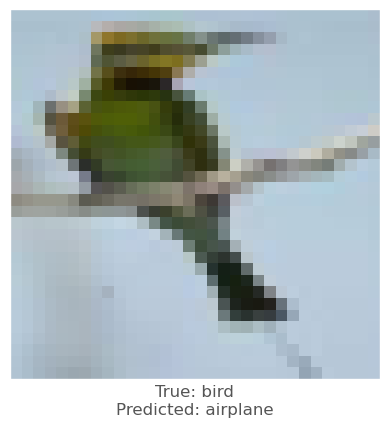

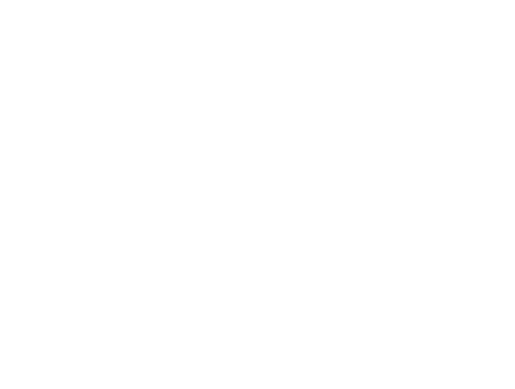

In [78]:
# No: 1, 3: Calculate the confidence values
# Yes: 118, 169, 2978, 658, 1001, 1116
# 1, 2, 3, 4, 5, 7, 10, 15, 20

image_id = 1297
pixels = 1 # Number of pixels to attack
model = lenet

_ = attack(image_id, model, pixel_count=pixels, verbose=True)


# plt.imshow(attack_image-x_test[image_id])
# plt.imshow(x_test[image_id])
plt.gca().set_axis_off()
plt.grid(False)

In [ ]:
# def attack_all(models, samples=500, pixels=(1,5,10,20), targeted=False, 
#                maxiter=75, popsize=400, verbose=False):
#     results = []
#     for model in models:
#         model_results = []
#         valid_imgs = correct_imgs[correct_imgs.name == model.name].img
#         img_samples = np.random.choice(valid_imgs, samples, replace=False)
        
#         for pixel_count in pixels:
#             for i, img_id in enumerate(img_samples):
#                 print('\n', model.name, '- image', img_id, '-', i+1, '/', len(img_samples))
#                 targets = [None] if not targeted else range(10)
                
#                 for target in targets:
#                     if targeted:
#                         print('Attacking with target', class_names[target])
#                         if target == y_test[img_id, 0]:
#                             continue
#                     result = attack(img_id, model, target, pixel_count, 
#                                     maxiter=maxiter, popsize=popsize, 
#                                     verbose=verbose)
#                     model_results.append(result)
                    
#         results += model_results
#         helper.checkpoint(results, targeted)
#     return results

In [ ]:
# untargeted = attack_all(models, samples=90, targeted=False)

In [ ]:
# # Find the number of columns in the first row of the data
# num_columns = len(untargeted[0])

# # Create a list of column names
# columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']

# # If the number of columns in the data is greater than the length of the `columns` list, add 'extra_column_i' for each extra column
# for i in range(len(columns), num_columns):
#     columns.append(f'extra_column_{i}')

# # Create the DataFrame with the updated `columns` list
# untargeted_results = pd.DataFrame(untargeted, columns=columns)

In [ ]:
# helper.attack_stats(untargeted_results, models, network_stats)